# Regression example: Optimization of the marginal likelihood and prediction
1. [Toy data with known additive structure](#dataset)
2. [Training the Laplace-approximated neural additive model (LA-NAM)](#LANAM)
    1. [post-hoc method: fitting and optimizing LA on a standard MLE-trained neural additive model](#posthoc)
    2. [online method: joint optimization of marginal likelihood and prediction](#joint)

In [1]:
import time 
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import parameters_to_vector, vector_to_parameters
import matplotlib.pyplot as plt 
import numpy as np

from LANAM.models import LaNAM, NAM, BayesianLinearRegression
from LANAM.config import defaults, nam_defaults
from LANAM.trainer import *
from LANAM.trainer.nam_trainer import *
from LANAM.data import *

from LANAM.utils.plotting import * 
from LANAM.utils.output_filter import OutputFilter
from LANAM.utils.wandb import *

from laplace import Laplace
from laplace import marglik_training as lamt
from laplace.curvature.backpack import BackPackGGN

In [2]:
%reload_ext autoreload
%autoreload 2

## Toy data with known additive structure<a id='dataset'></a>
We firstly set up the data with additive structure $\hat{f}(x_1, x_2, x_3, x_4) = \hat{f}_1(x_1) +\hat{f}_2(x_2) +\hat{f}_3(x_3) +\hat{f}_4(x_4)$ where
$$
\begin{aligned}
\hat{f}_1(x_1) &= 8 (x_1 - \frac{1}{2})^2, \\
\hat{f}_2(x_2) &= \frac{1}{10} \exp [-8x_2 + 4], \\
\hat{f}_3(x_3) &= 5 \exp [-2(2x_3 -1)^2], \\
\hat{f}_4(x_4) &= 0, 
\end{aligned}
$$
Different distributions are used for training and test data: 

$N=400$ noisy observation $\{x_n, y_n\}^N_ {n=1}$ is generated by sampling $x_n$ from normal distribution $\mathcal{N}(0.5, 0.2^2)$ truncated within $[0, 1]$ and generating targets $y_n = \hat{f}(x_n) + \epsilon_n$, where $\epsilon \sim \mathcal{N}(0, 0.7^2)$ is random Gaussian noise.

$N=1000$ test points is generated by sampling $x_n$ uniformly from $U([0, 1]^4)$. 

In [3]:
sigma = 0.7
# training and validation sets
data = load_synthetic_data(sigma=sigma, sampling_type='normal', num_samples=150, x_lims=(0, 1))
train_dl, train_dl_fnn, val_dl, val_dl_fnn = data.train_dataloaders()
in_features = data.in_features
indices = data.train_dl.dataset.indices
X_train, y_train, fnn_train = data.features[indices], data.y[indices], data.feature_targets[indices]

test_data = load_synthetic_data(x_lims=(0, 1), sigma=sigma, sampling_type='uniform',num_samples=1000)
test_dl, test_dl_fnn = test_data.test_dataloaders()
test_samples = test_data.get_test_samples()
X_test, y_test, fnn_test = test_samples

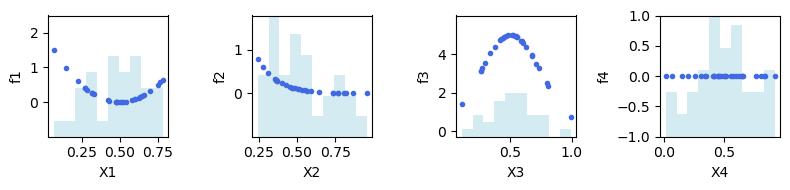

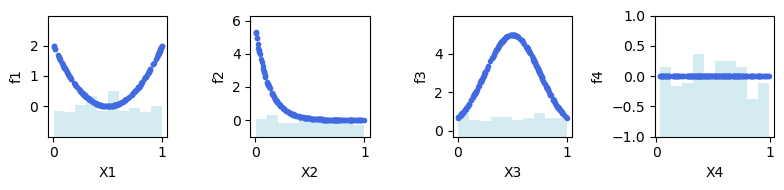

In [4]:
data.plot_dataset()
test_data.plot_dataset()

## Training the Laplace-approximated neural additive model (LA-NAM)<a id='LANAM'></a>
### Post-hoc method: fitting and optimizing LA on a standard MLE-trained neural additive model <a id='posthoc'></a>
With the standard MLE-trained neural additive model, we can estimate prior precision and observation noise after training: we fit LA to the training data and minimize the negative log marginal likelihood. 

In [5]:
cfg = defaults()
lanam = LaNAM(config=cfg, name="LA-NAM", in_features=in_features, hessian_structure='full', subset_of_weights='all')
loss = mle_train(cfg, lanam, train_dl, val_dl)

[EPOCH 1]: loss_train:  17.516, loss_val:  26.530
[EPOCH 251]: loss_train:  0.443, loss_val:  0.723
[EPOCH 501]: loss_train:  0.427, loss_val:  0.691
[EPOCH 751]: loss_train:  0.408, loss_val:  0.704


In [6]:
lanam.fit(loss, train_dl_fnn)

Before optimizing with the marginal likelihood. 

In [7]:
print(f'default observation noise: {lanam.additive_sigma_noise: .4f}')

default observation noise:  2.0000


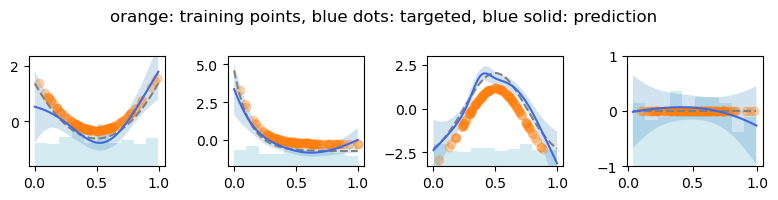

In [8]:
f_mu, f_var, f_mu_fnn, f_var_fnn = lanam.predict(X_test)
fig = plot_recovered_functions(X_test, y_test, fnn_test, f_mu_fnn, f_var_fnn, X_train, fnn_train)    

Now we initialized `log_prior` and `log_sigma` and minimize the log negative marginal likelihood using Adam.

In [9]:
log_prior, log_sigma = torch.ones(in_features, requires_grad=True), torch.ones(in_features, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
for i in range(1000):
    hyper_optimizer.zero_grad()
    neg_marglik = - lanam.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

In [10]:
print(f'found observation noise: {lanam.additive_sigma_noise: .4f}')

found observation noise:  0.7089


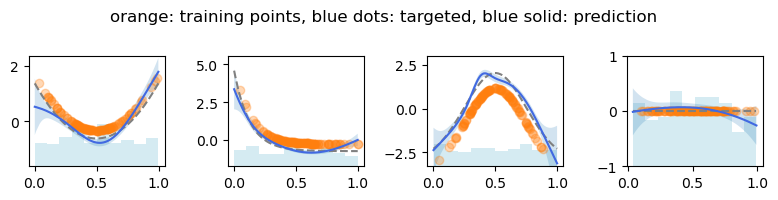

In [11]:
f_mu, f_var, f_mu_fnn, f_var_fnn = lanam.predict(X_test)
fig = plot_recovered_functions(X_test, y_test, fnn_test, f_mu_fnn, f_var_fnn, X_train, fnn_train)    

### online method: joint optimzation of marginal likelihood and prediction<a id='joint'></a>
Now we optimize LA-NAM jointly with MAP and marginal likelihood maximization. LA-NAM correctly ignores the uninformative feature.

In [12]:
cfg = defaults()
lanam = LaNAM(config=cfg, name="LA-NAM", in_features=in_features, hessian_structure='full', subset_of_weights='all')

In [13]:
lanam, margs, losses, perfs = marglik_training(lanam, 
                                               train_dl, 
                                               train_dl_fnn, 
                                               test_dl, 
                                               likelihood='regression', 
                                               test_samples=test_samples,
                                               n_epochs=500, 
                                               use_wandb=False, 
                                               optimizer_kwargs={'lr': 1e-2}, )

features, targets, feature_targets = test_samples

[Epoch=100, MSE:  1.607, n_hypersteps=29]: additive sigma noise= 1.257
[Epoch=200, MSE:  1.523, n_hypersteps=29]: additive sigma noise= 1.310
[Epoch=300, MSE:  1.191, n_hypersteps=29]: additive sigma noise= 1.154
[Epoch=400, MSE:  0.525, n_hypersteps=29]: additive sigma noise= 0.730
[Epoch=500, MSE:  0.465, n_hypersteps=29]: additive sigma noise= 0.740
MARGLIK: finished training. Recover best model and fit Laplace.


In [14]:
print(f'found observation noise: {lanam.additive_sigma_noise: .4f}')

found observation noise:  0.7405


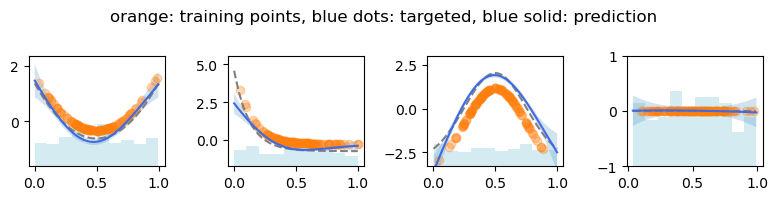

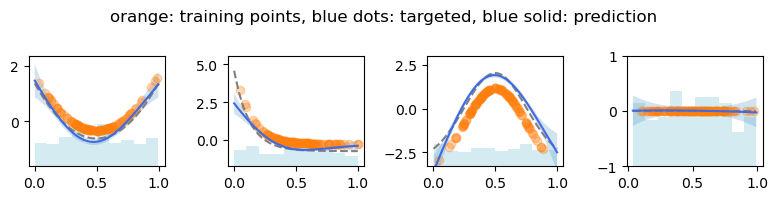

In [15]:
f_mu, f_var, f_mu_fnn, f_var_fnn = lanam.predict(X_test)
plot_recovered_functions(X_test, y_test, fnn_test, f_mu_fnn, f_var_fnn, X_train, fnn_train)    